In [90]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from PIL import Image
import os
from diffusers import UNet2DModel, DDPMScheduler

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

dataset = CustomDataset(image_dir='/local_dir/Train_Images', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)  # Adjust batch size and num_workers

In [91]:
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler

class SimpleDDPM(pl.LightningModule):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = UNet2DModel(
            sample_size=(64, 2048),
            in_channels=1,  # Single channel for grayscale images
            out_channels=1,  # Single channel output
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x, t):
        return self.model(x, t).sample

    def training_step(self, batch, batch_idx):
        images = batch.to(self.device)
        t = torch.randint(0, self.scheduler.config.num_train_timesteps, (images.size(0),), device=self.device).long()
        noise = torch.randn_like(images).to(self.device)
        noisy_images = self.scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)

        predicted_noise = self(noisy_images, t)
        loss = self.criterion(predicted_noise, noise)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [ ]:
# Check for GPU availability and initialize the Trainer accordingly
if torch.cuda.is_available():
    accelerator = 'gpu'
    devices = 1
else:
    accelerator = 'cpu'
    devices = 1
    
trainer = pl.Trainer(
    accumulate_grad_batches=4,  # Gradient accumulation
    precision=16,  # Mixed precision
    max_epochs=100,
    accelerator='gpu',
    devices=1
)

model = SimpleDDPM()

In [98]:
# Train the model
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode
-------------------------------------------------
0 | model     | UNet2DModel | 56.6 M | eval
1 | criterion | MSELoss     | 0      | eval
-------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.289   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]



0it [00:00, ?it/s]

5it [00:00, 49.67it/s]

10it [00:00, 47.33it/s]

15it [00:00, 46.74it/s]

20it [00:00, 46.33it/s]

25it [00:00, 46.25it/s]

30it [00:00, 46.11it/s]

35it [00:00, 46.06it/s]

40it [00:00, 46.02it/s]

45it [00:00, 45.96it/s]

50it [00:01, 45.90it/s]

55it [00:01, 45.87it/s]

60it [00:01, 45.90it/s]

65it [00:01, 45.81it/s]

70it [00:01, 45.86it/s]

75it [00:01, 45.78it/s]

80it [00:01, 45.85it/s]

85it [00:01, 45.80it/s]

90it [00:01, 45.85it/s]

95it [00:02, 45.80it/s]

100it [00:02, 45.79it/s]

105it [00:02, 45.71it/s]

110it [00:02, 45.76it/s]

115it [00:02, 45.81it/s]

120it [00:02, 45.73it/s]

125it [00:02, 45.81it/s]

130it [00:02, 45.74it/s]

135it [00:02, 45.82it/s]

140it [00:03, 45.80it/s]

145it [00:03, 45.87it/s]

150it [00:03, 45.84it/s]

155it [00:03, 45.87it/s]

160it [00:03, 45.81it/s]

165it [00:03, 45.80it/s]

170it [00:03, 45.82it/s]

175it [00:03, 46.40it/s]

180it [00:03, 46.69it/s]

185it [00:04, 46.71it/s]

190it [00:04, 46.77it/s]

195it [00:

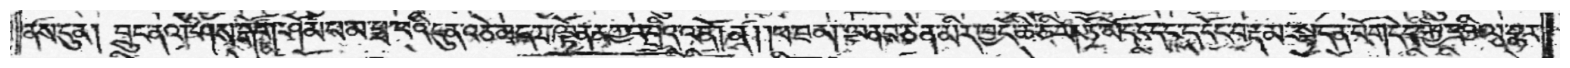

In [99]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# Generate and Visualize Images
model.eval()
with torch.no_grad():
    num_images = 1
    noise = torch.randn(num_images, 1, 64, 2048).to('cuda')  # Adjust to grayscale and new size
    for t in tqdm(reversed(range(model.scheduler.config.num_train_timesteps))):
        model_output = model(noise, t)
        noise = model.scheduler.step(model_output, t, noise).prev_sample

    generated_images = (noise + 1) / 2  # Convert [-1, 1] to [0, 1]

# Plot generated images
fig, axs = plt.subplots(num_images, 1, figsize=(20, num_images * 2))
if num_images == 1:
    axs.imshow(generated_images[0].cpu().squeeze(), cmap='gray')
    axs.axis("off")
else:
    for i in range(num_images):
        axs[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axs[i].axis("off")
plt.show()